In [1]:
#!pip install prophet

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
from prophet import Prophet, plot

%matplotlib inline
plt.style.use('fivethirtyeight')


In [13]:
mongo_uri = "mongodb://hadoop-vm.internal.cloudapp.net:27017/ca2"

client = MongoClient(mongo_uri)
db = client["ca2"]
collection = db["vaccin_tweets_analysis"]

# Convert MongoDB collection to pandas DataFrame
df = pd.DataFrame(list(collection.find()))


In [19]:
df = df[["timestamp","sentiment_score"]]
df["timestamp"] = df["timestamp"].apply(lambda x: pd.to_datetime(x).date())
df.rename(columns={"timestamp": "ds", "sentiment_score": "y"},inplace=True)

In [77]:
df_grouped = df.groupby('ds')['y'].mean()

In [78]:
data = df_grouped.reset_index()

# Prophet model

In [79]:
# Get 1 year of data
start_date = pd.to_datetime("2020-04-01").date()
split_date = pd.to_datetime("2020-12-31").date()
end_date = pd.to_datetime("2021-05-01").date()
train = data.loc[(data.ds >= start_date) & (data.ds <= split_date)]
test = data.loc[(data.ds >= split_date) & (data.ds <= end_date)]

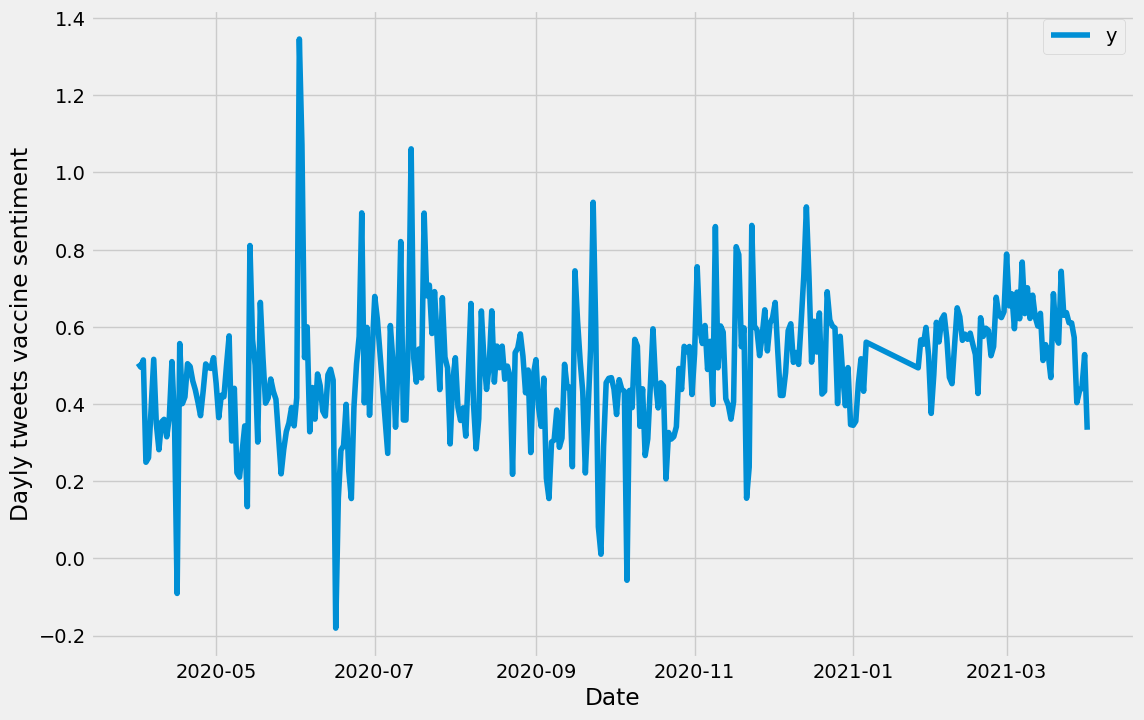

In [80]:
ax = data.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Dayly tweets vaccine sentiment')
ax.set_xlabel('Date')

plt.show()

In [81]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
model = Prophet(interval_width=0.95)

In [82]:
model.fit(train)

22:51:06 - cmdstanpy - INFO - Chain [1] start processing
22:51:06 - cmdstanpy - INFO - Chain [1] done processing


In [83]:
# 7 days forecast

In [84]:
sevend_days_prediction_dates = model.make_future_dataframe(periods=7, freq='D', include_history=False)
one_month_prediction_dates = model.make_future_dataframe(periods=30, freq='D', include_history=False)
three_months_prediction_dates = model.make_future_dataframe(periods=90, freq='D', include_history=False)

In [85]:
seven_days_predictions = model.predict(sevend_days_prediction_dates)
one_month_predictions = model.predict(one_month_prediction_dates)
three_months_predictions = model.predict(three_months_prediction_dates)
seven_days_predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-01-01,0.544311,0.175087,0.858250
1,2021-01-02,0.496240,0.168367,0.806977
2,2021-01-03,0.446843,0.132393,0.787476
3,2021-01-04,0.551722,0.228966,0.861340
4,2021-01-05,0.557538,0.220898,0.877069


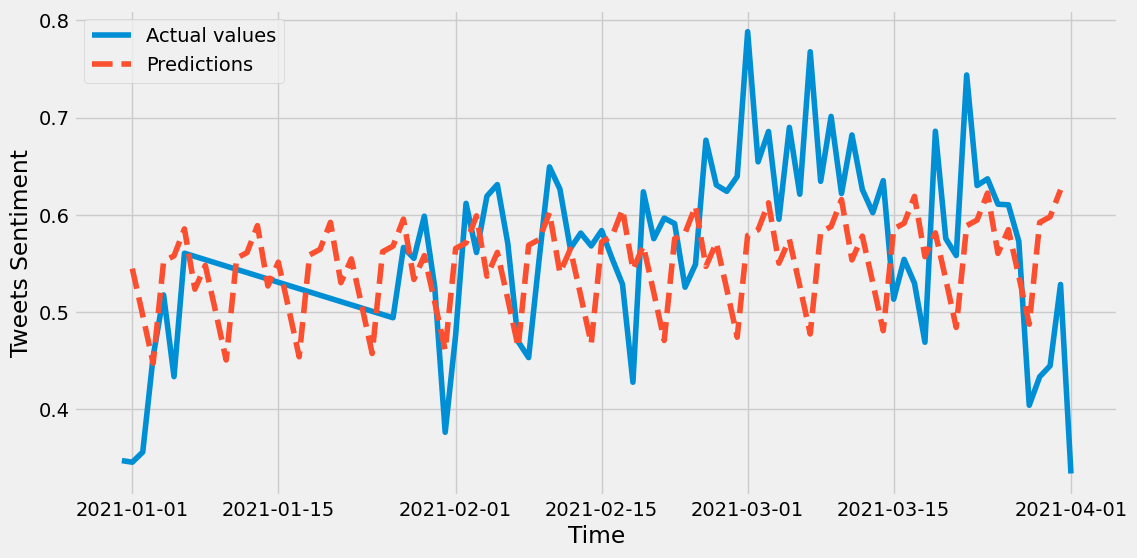

In [97]:
# Note there is missing dates on January 2021 on the dataset.
# https://archive.org/download/archiveteam-twitter-stream-2021-01
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test.ds, test.y, label='Actual values')
plt.plot(three_months_predictions.ds, three_months_predictions.yhat, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Tweets Sentiment')
plt.legend()
plt.show()

# Crossvalidation and Hyper parameter tunning

In [112]:
events = {
    #'2020-03-27': {'postive':0,'description': 'Ireland\nLocked down', 'url': "about:0"  },
    '2020-05-18': {'postive':1,'description': 'Moderna\nFirst Trial', 'url': "https://www.theguardian.com/society/2020/may/18/first-human-trial-results-raise-hopes-for-coronavirus-vaccine"  },
    '2020-07-21': {'postive':0,'description': 'Vaccine\nSide effects', 'url': 'https://www.wired.com/story/covid-19-vaccines-with-minor-side-effects-could-still-be-pretty-bad/'},    
    '2020-09-08': {'postive':0,'description': 'AstraZeneca\nSuspends trials', 'url': 'https://www.reuters.com/article/us-health-coronavirus-astrazeneca-idUSKBN25Z392'},    
    '2020-10-13': {'postive':1,'description': 'Pfizer\npositive results', 'url': 'https://www.pfizer.com/news/press-release/press-release-detail/pfizer-and-biontech-announce-positive-early-data-clinical'},
    '2020-12-03': {'postive':1,'description': 'UK\napproved Pfize vaccine', 'url': 'https://www.nature.com/articles/d41586-020-03441-8'},
}

In [131]:
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

cutoffs = pd.to_datetime(list(events.keys()))

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive','multiplicative'],
    'changepoint_range': [0.8, 0.95],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='28 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

23:21:12 - cmdstanpy - INFO - Chain [1] start processing
23:21:12 - cmdstanpy - INFO - Chain [1] done processing
23:21:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
23:21:12 - cmdstanpy - INFO - Chain [1] start processing
23:21:13 - cmdstanpy - INFO - Chain [1] done processing
23:21:19 - cmdstanpy - INFO - Chain [1] start processing
23:21:19 - cmdstanpy - INFO - Chain [1] done processing
23:21:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
23:21:19 - cmdstanpy - INFO - Chain [1] start processing
23:21:20 - cmdstanpy - INFO - Chain [1] done processing
23:21:26 - cmdstanpy - INFO - Chain [1] start processing
23:21:26 - cmdstanpy - INFO - Chain [1] done processing
23:21:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newto

23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing
23:26:14 - cmdstanpy - INFO - Chain [1] start processing
23:26:14 - cmdstanpy - INFO - Chain [1] done processing
23:26:23 - cmdstanpy - INFO - Chain [1] start processing
23:26:23 - cmdstanpy - INFO - Chain [1] done processing
23:26:33 - cmdstanpy - INFO - Chain [1] start processing
23:26:33 - cmdstanpy - INFO - Chain [1] done processing
23:26:41 - cmdstanpy - INFO - Chain [1] start processing
23:26:41 - cmdstanpy - INFO - Chain [1] done processing
23:26:48 - cmdstanpy - INFO - Chain [1] start processing
23:26:48 - cmdstanpy - INFO - Chain [1] done processing
23:26:56 - cmdstanpy - INFO - Chain [1] start processing
23:26:56 - cmdstanpy - INFO - Chain [1] done processing
23:27:03 - cmdstanpy - INFO - Chain [1] start processing
23:27:04 - cmdstanpy - INFO - Chain [1] done processing
23:27:11 - cmdstanpy - INFO - Chain [1] start processing
23:27:11 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01         additive   
2                     0.001                     0.01   multiplicative   
3                     0.001                     0.01   multiplicative   
4                     0.001                     0.10         additive   
..                      ...                      ...              ...   
75                    1.000                     1.00   multiplicative   
76                    1.000                    10.00         additive   
77                    1.000                    10.00         additive   
78                    1.000                    10.00   multiplicative   
79                    1.000                    10.00   multiplicative   

    changepoint_range      rmse  
0                0.80  0.189218  
1                0.95  0.187387  
2                0.80

In [132]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


In [133]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    changepoint_range=best_params['changepoint_range'],
        )

In [134]:
model.fit(train)

23:36:10 - cmdstanpy - INFO - Chain [1] start processing
23:36:10 - cmdstanpy - INFO - Chain [1] done processing


In [135]:
three_months_predictions = model.predict(three_months_prediction_dates)

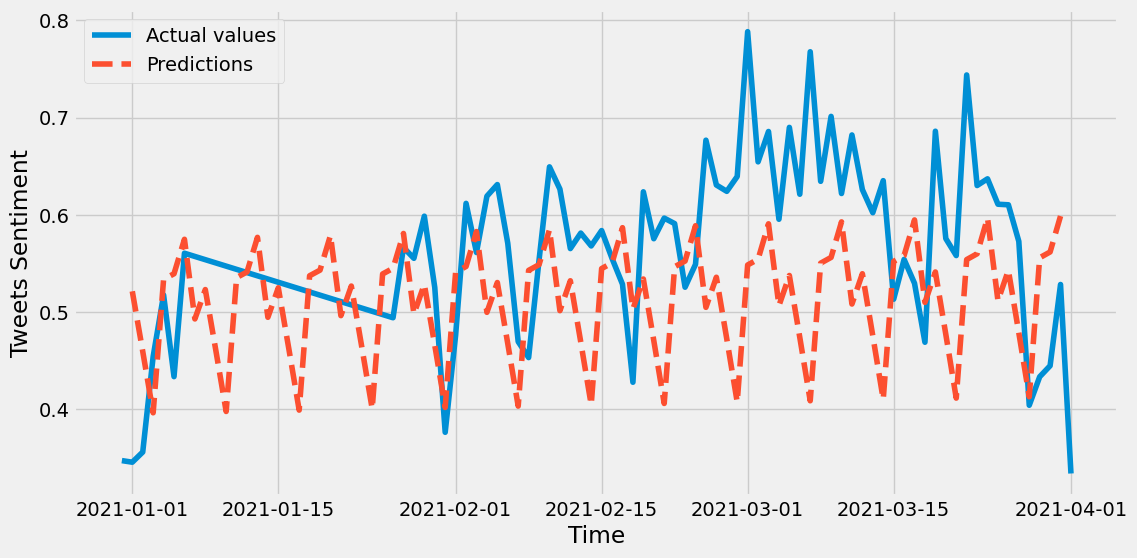

In [136]:
# Note there is missing dates on January 2021 on the dataset.
# https://archive.org/download/archiveteam-twitter-stream-2021-01
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test.ds, test.y, label='Actual values')
plt.plot(three_months_predictions.ds, three_months_predictions.yhat, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Tweets Sentiment')
plt.legend()
plt.show()

# Best Model selection parameters
```
{
    'changepoint_prior_scale': 0.01,
    'seasonality_prior_scale': 10.0,
    'seasonality_mode': 'multiplicative',
    'changepoint_range': 0.8
}
```